In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import multiprocessing
from scipy import signal
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from model_src.DilatedResNet import DilatedResNet
from model_src.BianResnet import BianResNet
from model_src.LSTM import VanillaLSTM, CNNLSTM, BiLSTM, BiLSTMAttn
from model_src.RespNet import RespNet

physical_devices = tf.config.list_physical_devices('GPU')
print(f'Is GPU Avaliable: {physical_devices[0]}')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
DATA_PATH = '/root/Workspace/DataLake/stMary'
DATA_SAVE_PATH = '/root/Workspace/Project-RRpo-2ndStudy/dataset' 

Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is GPU Avaliable: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
EPOCHS = 1000
BATCH_SIZE = 256
LR = 0.001
callbacks = [
    EarlyStopping(monitor='val_loss', patience=33),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
]

In [3]:
def gen_tfdataset(dataset, batchsize):
    X = []; y = []
    for pleth, resp in dataset:
        X.append(pleth.astype(np.float32))
        y.append(resp)

    X = np.array(X); y = np.array(y).reshape(-1,1)
    scaler = MinMaxScaler()
    scaled_X = np.asarray([scaler.fit_transform(pleth.reshape(-1,1)) for pleth in X])
    print(f'Overall: {scaled_X.shape}, {y.shape}')
    return tf.data.Dataset.from_tensor_slices((scaled_X, y)).batch(batchsize)


def cross_validation(model, model_name, dataset, dataset_name, n_splits=5, batch_size=256, lr=0.001):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    # kf = KFold(n_splits=n_splits)
    train_losses = []; val_losses = []
    subject_id = np.array([subject[0] for subject in dataset])
    count = 1
    
    for train_idx, val_idx in kf.split(subject_id):
        obj_model = model()
        # obj_model = model(num_of_blocks=4, kernel_size=2, dilation_rate=3, dwn_kernel_size=3, filters=8, strides_of_avg=2, units=86)
        
        train_dataset = []; val_dataset = []
        for id, samples in dataset:
                if id in subject_id[train_idx]: train_dataset.extend(samples)
                else: val_dataset.extend(samples)
        
        train_dataset = np.array(train_dataset); val_dataset = np.array(val_dataset)

        train_tf = gen_tfdataset(train_dataset, batch_size)
        val_tf = gen_tfdataset(val_dataset, batch_size)

        obj_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss=keras.losses.MeanAbsoluteError(),
            metrics=keras.metrics.MeanAbsoluteError()
        )  

        callbacks.append(ModelCheckpoint(
            filepath=f'../models/230924/{dataset_name}/{model_name}/{model_name}-{dataset_name}-KF{count}/ckpt', 
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_weights_only=True))

        history = obj_model.fit(
            train_tf,
            epochs=EPOCHS,
            callbacks=callbacks,
            validation_data=val_tf
        )

        callbacks.pop()

        min_val_loss_idx = np.argmin(history.history['val_loss'])
        train_losses.append(history.history['loss'][min_val_loss_idx])
        val_losses.append(history.history['val_loss'][min_val_loss_idx])
        count = count + 1
    
    print(f'TRAIN: {np.mean(train_losses)} ± {np.std(train_losses)}')
    print(f'VAL: {np.mean(val_losses)} ± {np.std(val_losses)}')
    return train_losses, val_losses

## Experiments
성모병원 데이터셋 `stmary-trainval_dataset.npy`를 이용해서 7개의 모델을 학습시킨다. 

해당 학습 모델들은 다음과 같이 저장시킨다: `stmary-<Model name>`

이외의 학습 파라메터는 아래와 같다:
- Epochs: `1000`

- Batch size: `256`

- Learning rate: `0.001`

- callbacks: `EarlyStopping(monitor='val_loss', patience=33),ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)`

또한 7개의 모델 각각에 대한 하이퍼 파라메터 조정은 아래와 같이 이루어졌다:
- Bian model: 논문(`10.1109/EMBC44109.2020.9176231`)의 파라메터를 따랐다.

- Unet model: 논문(`10.1109/embc.2019.8856301`)의 파라메터를 따랐다.

- LSTM family model: 논문(`10.1016/j.compbiomed.2022.105338`)의 파라메터를 따랐다.

- Proposed model: Bayesian optimization을 적용하였다.
    + `num_of_blocks`: RespBlk의 블록 개수 [1 ~ 5]

    + `kernel_size`: RespBlk의 kernel 크기 [2 ~ 5]

    + `dilation_rate`: RespBlk 내 Convolution layer들의 Dilation 정도 [0 ~ 5]

    + `dwn_kernel_size`: Downsample을 위한 1Dconvolution의 kernel_size [2 ~ 4]

    + `filters`: 필터 개수, 블록의 반복마다 2의 제곱배 되어 증가한다. [4 ~ 10]

    + `strides`: Average pooling의 stride 크기 [2 ~ 4]

    + `units`: 첫번째 Dense layer의 unit 수 [20 ~ 100]

- 학습할 모델:
    모델을 학습할 때는 `LOSO method`를 따르며, `5-Fold CV`를 시행한다.
    + 1. StMary-based Models: `stmary-trainval_dataset.npy`으로 학습 및 조정한다.

    + 2. BIDMC-based Models: `bidmc-trainval_dataset.npy`으로 학습 및 조정한다.

- Experiment 1:
    + 1번 모델을 `stmary-test_dataset.npy`로 최종 검증한다.

- Experiment 2:
    + 1번 모델을 `stmary-test_dataset.npy`로 호흡 속도에 따라 따로 검증한다.

- Experiment 3:
    + 1번 모델을 `bidmc-preprocessed.npy`와 `capno-preprocessed.npy`, 그리고 그 각각의 호흡 속도에 따라 따로 검증한다.

- Experiment 4:
    + 2번 모델을 `stmary-preprocessed.npy`와 `capno-preprocessed.npy`, 그리고 그 각각의 호흡 속도에 따라 따로 검증한다.

In [4]:
stmary = np.load(f'{DATA_SAVE_PATH}/230920/stmary-trainval_dataset.npy', allow_pickle=True)
print(stmary.shape)

(85, 2)


In [5]:
bidmc = np.load(f'{DATA_SAVE_PATH}/230921/bidmc-trainval_dataset.npy', allow_pickle=True)
print(bidmc.shape)

(43, 2)


## Modeling with StMary

In [5]:
# models = [BianResNet(), RespNet(), VanillaLSTM(), CNNLSTM(), BiLSTM(), BiLSTMAttn()]
# model_names = ['Bian', 'RespNet', 'LSTM', 'CNNLSTM', 'BiLSTM', 'BiLSTMAttn']
models = [VanillaLSTM]
model_names = ['LSTM']

In [6]:
results = np.array([(model_names[i], cross_validation(model, model_name=model_names[i], dataset=stmary, dataset_name='stmary', n_splits=5, batch_size=BATCH_SIZE, lr=LR)) for i, model in enumerate(models)])

Overall: (4483, 1800, 1), (4483, 1)
Overall: (1129, 1800, 1), (1129, 1)
Epoch 1/1000
18/18 [==============================] - 12s 387ms/step - loss: 10.6650 - mean_absolute_error: 10.6650 - val_loss: 4.7543 - val_mean_absolute_error: 4.7543 - lr: 0.0010
Epoch 2/1000
18/18 [==============================] - 6s 355ms/step - loss: 5.3293 - mean_absolute_error: 5.3293 - val_loss: 4.2706 - val_mean_absolute_error: 4.2706 - lr: 0.0010
Epoch 3/1000
18/18 [==============================] - 6s 357ms/step - loss: 5.6261 - mean_absolute_error: 5.6261 - val_loss: 3.9364 - val_mean_absolute_error: 3.9364 - lr: 0.0010
Epoch 4/1000
18/18 [==============================] - 6s 353ms/step - loss: 5.1163 - mean_absolute_error: 5.1163 - val_loss: 4.4122 - val_mean_absolute_error: 4.4122 - lr: 0.0010
Epoch 5/1000
18/18 [==============================] - 6s 355ms/step - loss: 4.5775 - mean_absolute_error: 4.5775 - val_loss: 4.1438 - val_mean_absolute_error: 4.1438 - lr: 0.0010
Epoch 6/1000
18/18 [==========

In [7]:
results

array([['LSTM',
        ([4.532455921173096, 4.63864278793335, 4.669713020324707, 4.425944805145264, 4.628583908081055], [3.9232139587402344, 4.383017539978027, 5.0109333992004395, 3.999845266342163, 4.166919231414795])]],
      dtype=object)

## Modeling with BIDMC

In [5]:
# models = [BianResNet(), RespNet(), VanillaLSTM(), CNNLSTM(), BiLSTM(), BiLSTMAttn()]
# model_names = ['Bian', 'RespNet', 'LSTM', 'CNNLSTM', 'BiLSTM', 'BiLSTMAttn']
models = [RespNet]
model_names = ['RespNet']

In [6]:
results = np.array([(model_names[i], cross_validation(model, model_name=model_names[i], dataset=bidmc, dataset_name='bidmc', n_splits=5, batch_size=BATCH_SIZE, lr=LR)) for i, model in enumerate(models)])

Overall: (14314, 1800, 1), (14314, 1)
Overall: (3789, 1800, 1), (3789, 1)
Epoch 1/1000
56/56 [==============================] - 85s 705ms/step - loss: 8.5011 - mean_absolute_error: 8.5011 - val_loss: 5.6558 - val_mean_absolute_error: 5.6558 - lr: 0.0010
Epoch 2/1000
56/56 [==============================] - 34s 600ms/step - loss: 2.3614 - mean_absolute_error: 2.3614 - val_loss: 2.2466 - val_mean_absolute_error: 2.2466 - lr: 0.0010
Epoch 3/1000
56/56 [==============================] - 33s 594ms/step - loss: 2.2966 - mean_absolute_error: 2.2966 - val_loss: 2.3716 - val_mean_absolute_error: 2.3716 - lr: 0.0010
Epoch 4/1000
56/56 [==============================] - 33s 595ms/step - loss: 2.1090 - mean_absolute_error: 2.1090 - val_loss: 2.9827 - val_mean_absolute_error: 2.9827 - lr: 0.0010
Epoch 5/1000
56/56 [==============================] - 33s 595ms/step - loss: 2.1274 - mean_absolute_error: 2.1274 - val_loss: 2.2814 - val_mean_absolute_error: 2.2814 - lr: 0.0010
Epoch 6/1000
56/56 [======

In [8]:
results

array([['DilatedResNet',
        ([0.8564647436141968, 0.963432788848877, 1.0826908349990845, 1.278597354888916, 1.439195156097412], [1.3207523822784424, 0.9285268783569336, 0.9753350019454956, 1.6040254831314087, 1.4852333068847656])]],
      dtype=object)

## Hyper-parameter tuning

In [6]:
from bayes_opt import BayesianOptimization

In [13]:
def optimize_model(N_blk, kernel_blk, d_blk, kernel_dwn, filters_c, s_c, n_den):
    kf = KFold(n_splits=5)
    train_losses = []; val_losses = []
    subject_id = np.array([subject[0] for subject in bidmc])
    count = 1
    for train_idx, val_idx in kf.split(subject_id):
        model = DilatedResNet(num_of_blocks=int(N_blk), kernel_size=int(kernel_blk), dilation_rate=int(d_blk), dwn_kernel_size=int(kernel_dwn), filters=int(filters_c), strides_of_avg=int(s_c), units=int(n_den))
        
        train_dataset = []; val_dataset = []
        for id, samples in bidmc:
            if id in subject_id[train_idx]: train_dataset.extend(samples)
            else: val_dataset.extend(samples)
        
        train_dataset = np.array(train_dataset); val_dataset = np.array(val_dataset)
        train_tf = gen_tfdataset(train_dataset, 256)
        val_tf = gen_tfdataset(val_dataset, 256)

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=33),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
        ]

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=keras.losses.MeanAbsoluteError(),
            metrics=keras.metrics.MeanAbsoluteError()
        )

        history = model.fit(
            train_tf,
            epochs=1000,
            callbacks=callbacks,
            validation_data=val_tf,
            verbose=0
        )

        min_val_loss_idx = np.argmin(history.history['val_loss'])
        train_losses.append(history.history['loss'][min_val_loss_idx])
        val_losses.append(history.history['val_loss'][min_val_loss_idx])
    
    return 100 - np.mean(val_losses)

In [14]:
optimizer = BayesianOptimization(
    f=optimize_model,
    pbounds={
        'N_blk': (1,5),
        'kernel_blk': (2,5), 
        'd_blk': (1,5), 
        'kernel_dwn': (2,4), 
        'filters_c': (4,10), 
        's_c': (2,4), 
        'n_den': (20, 100)
    },
    random_state=42,
    verbose=2
)
optimizer.maximize(n_iter=5)
print(f'Final result: {optimizer.max}')

|   iter    |  target   |   N_blk   |   d_blk   | filters_c | kernel... | kernel... |   n_den   |    s_c    |
-------------------------------------------------------------------------------------------------------------
Overall: (14314, 1800, 1), (14314, 1)
Overall: (3789, 1800, 1), (3789, 1)
Overall: (14314, 1800, 1), (14314, 1)
Overall: (3789, 1800, 1), (3789, 1)
Overall: (14314, 1800, 1), (14314, 1)
Overall: (3789, 1800, 1), (3789, 1)
Overall: (14735, 1800, 1), (14735, 1)
Overall: (3368, 1800, 1), (3368, 1)
Overall: (14735, 1800, 1), (14735, 1)
Overall: (3368, 1800, 1), (3368, 1)
| 1         | 98.77     | 2.498     | 4.803     | 8.392     | 3.796     | 2.312     | 32.48     | 2.116     |
Overall: (14314, 1800, 1), (14314, 1)
Overall: (3789, 1800, 1), (3789, 1)
Overall: (14314, 1800, 1), (14314, 1)
Overall: (3789, 1800, 1), (3789, 1)
Overall: (14314, 1800, 1), (14314, 1)
Overall: (3789, 1800, 1), (3789, 1)
Overall: (14735, 1800, 1), (14735, 1)
Overall: (3368, 1800, 1), (3368, 1)
Over

In [15]:
print(f'Final result: {optimizer.max}')

Final result: {'target': 98.78833994865417, 'params': {'N_blk': 4.46470458309974, 'd_blk': 3.404460046972835, 'filters_c': 8.248435466776273, 'kernel_blk': 2.0617534828874073, 'kernel_dwn': 3.9398197043239884, 'n_den': 86.59541126403374, 's_c': 2.4246782213565523}}


## Check Best

In [12]:
def check_result(model_path, models, model_names, dataset, dataset_name, n_splits):
    # validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_losses = []; val_losses = []
    subject_id = np.array([subject[0] for subject in dataset])

    for model_name, model in zip(model_names, models):
        train_loss = []; val_loss = []
        count = 0
        loaded_files = sorted(os.listdir(f'{model_path}/{dataset_name}/{model_name}'))
        for train_idx, val_idx in kf.split(subject_id):
            # load_model = model()
            load_model = model(num_of_blocks=4, kernel_size=2, dilation_rate=3, dwn_kernel_size=3, filters=8, strides_of_avg=2, units=86)
            load_model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.MeanAbsoluteError(),
                metrics=keras.metrics.MeanAbsoluteError()
            )
            load_model.load_weights(f"{model_path}/{dataset_name}/{model_name}/{loaded_files[count]}/ckpt")
            train_dataset = []; val_dataset = []
            
            for id, samples in dataset:
                if id in subject_id[train_idx]: train_dataset.extend(samples)
                else: val_dataset.extend(samples)
            
            train_dataset = np.array(train_dataset); val_dataset = np.array(val_dataset)

            train_tf = gen_tfdataset(train_dataset, 256)
            val_tf = gen_tfdataset(val_dataset, 256)

            train_loss.append(load_model.evaluate(train_tf)[0])
            val_loss.append(load_model.evaluate(val_tf)[0])
            count += 1
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    return np.array(train_losses), np.array(val_losses)

In [15]:
train_losses, val_losses = check_result(
    model_path='../models/230924/',
    models=[DilatedResNet],
    model_names=['DilatedResNet'],
    dataset=bidmc,
    dataset_name='bidmc',
    n_splits=5
)

Overall: (14314, 1800, 1), (14314, 1)
Overall: (3789, 1800, 1), (3789, 1)
15/15 [==============================] - 1s 41ms/step - loss: 1.3208 - mean_absolute_error: 1.3208
Overall: (14314, 1800, 1), (14314, 1)
Overall: (3789, 1800, 1), (3789, 1)
15/15 [==============================] - 0s 23ms/step - loss: 0.9285 - mean_absolute_error: 0.9285
Overall: (14314, 1800, 1), (14314, 1)
Overall: (3789, 1800, 1), (3789, 1)
15/15 [==============================] - 0s 23ms/step - loss: 0.9753 - mean_absolute_error: 0.9753
Overall: (14735, 1800, 1), (14735, 1)
Overall: (3368, 1800, 1), (3368, 1)
14/14 [==============================] - 1s 38ms/step - loss: 1.6040 - mean_absolute_error: 1.6040
Overall: (14735, 1800, 1), (14735, 1)
Overall: (3368, 1800, 1), (3368, 1)
14/14 [==============================] - 0s 23ms/step - loss: 1.4852 - mean_absolute_error: 1.4852


In [16]:
print(np.array(train_losses), np.mean(np.array(train_losses), axis=1), np.std(np.array(train_losses), axis=1))
print(np.array(val_losses), np.mean(np.array(val_losses), axis=1), np.std(np.array(val_losses), axis=1))

[[1.05392969 1.35618937 1.39829373 1.15762174 1.33622801]] [1.26045251] [0.13201024]
[[1.32075238 0.92852688 0.975335   1.60402548 1.48523331]] [1.26277461] [0.26968297]


In [ ]:
# # validation
# kf = KFold(n_splits=5)
# train_losses = []; val_losses = []
# count = 0

# models = [BianResNet, RespNet, VanillaLSTM, CNNLSTM, BiLSTM, BiLSTMAttn]
# model_names = ['Bian', 'RespNet', 'LSTM', 'CNNLSTM', 'BiLSTM', 'BiLSTMAttn']
# dataset_name = 'bidmc'
# dataset = bidmc
# subject_id = np.array([subject[0] for subject in dataset])

# for model_name, model in zip(model_names, models):
#     val_loss = []
#     count = 0
#     loaded_files = sorted(os.listdir(f'../models/230921/{dataset_name}/{model_name}'))
#     for train_idx, val_idx in kf.split(subject_id):
#         load_model = model()
#         load_model.compile(
#             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#             loss=keras.losses.MeanAbsoluteError(),
#             metrics=keras.metrics.MeanAbsoluteError()
#         )
#         load_model.load_weights(f"../models/230921/{dataset_name}/{model_name}/{loaded_files[count]}/ckpt")
#         train_dataset = []; val_dataset = []
        
#         for id, samples in dataset:
#             if id in subject_id[train_idx]: train_dataset.extend(samples)
#             else: val_dataset.extend(samples)
        
#         train_dataset = np.array(train_dataset); val_dataset = np.array(val_dataset)

#         train_tf = gen_tfdataset(train_dataset, 256)
#         val_tf = gen_tfdataset(val_dataset, 256)

#         val_loss.append(load_model.evaluate(val_tf)[0])
#         count += 1
#     val_losses.append(val_loss)

## Test

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


def gen_signal(A=1, f=1, phi=0, t=360):
    t = np.linspace(0,1,t)
    return A*np.cos(2*np.pi*f*t + phi)


def plot_sig(sig):
    plt.figure(figsize=(20,3))
    plt.plot(sig)
    plt.show()


def get_resp_class(dataset):
    rapid_rr = []; normal_rr = []; slow_rr = []
    for id, samples in dataset:
        for sample in samples:
            if sample[1] < 12: slow_rr.append(sample)
            elif sample[1] > 20: rapid_rr.append(sample)
            else: normal_rr.append(sample)
    
    rapid_rr = np.array(rapid_rr)
    normal_rr = np.array(normal_rr)
    slow_rr = np.array(slow_rr)
    return rapid_rr, normal_rr, slow_rr


def get_trainable_X(dataset):
    scaler = MinMaxScaler()
    return np.expand_dims(scaler.fit_transform(np.vstack(dataset[:, 0])),axis=-1)


def get_predict_performance(model, X, y):
    y_pred = model.predict(X)
    return y - y_pred


def test_model(model_path='../models/230921', model=None, model_name=None, data_path='../dataset/test_dataset'):
    if model_name == 'stmary': stmary_test = np.load(f'{data_path}/stmary-test_dataset.npy', allow_pickle=True)
    else: stmary_test = np.load(f'{data_path}/stmary-preprocessed.npy', allow_pickle=True)
    stmary_rapid, stmary_normal, stmary_slow = get_resp_class(stmary_test)
    stmary_test = np.concatenate([stmary_rapid, stmary_normal, stmary_slow],axis=0)
    # stmary_tf_rapid, stmary_tf_normal, stmary_tf_slow, stmary_tf_test = gen_tfdataset(stmary_rapid, 256), gen_tfdataset(stmary_normal, 256), gen_tfdataset(stmary_slow, 256), gen_tfdataset(stmary_test, 256)
    
    X_stmary_np_rapid, y_stmary_np_rapid = get_trainable_X(stmary_rapid), stmary_rapid[:, 1].reshape(-1,1)
    X_stmary_np_normal, y_stmary_np_normal = get_trainable_X(stmary_normal), stmary_normal[:, 1].reshape(-1,1)
    X_stmary_np_slow, y_stmary_np_slow = get_trainable_X(stmary_slow), stmary_slow[:, 1].reshape(-1,1)
    X_stmary_np_test, y_stmary_np_test = get_trainable_X(stmary_test), stmary_test[:, 1].reshape(-1,1)

    if model_name == 'bidmc': bidmc_test = np.load(f'{data_path}/bidmc-test_dataset.npy', allow_pickle=True)
    else: bidmc_test = np.load(f'{data_path}/bidmc-preprocessed.npy', allow_pickle=True)
    bidmc_rapid, bidmc_normal, bidmc_slow = get_resp_class(bidmc_test)
    bidmc_test = np.concatenate([bidmc_rapid, bidmc_normal, bidmc_slow],axis=0)
    # bidmc_tf_rapid, bidmc_tf_normal, bidmc_tf_slow, bidmc_tf_test = gen_tfdataset(bidmc_rapid, 256), gen_tfdataset(bidmc_normal, 256), gen_tfdataset(bidmc_slow, 256), gen_tfdataset(bidmc_test, 256)

    X_bidmc_np_rapid, y_bidmc_np_rapid = get_trainable_X(bidmc_rapid), bidmc_rapid[:, 1].reshape(-1,1)
    X_bidmc_np_normal, y_bidmc_np_normal = get_trainable_X(bidmc_normal), bidmc_normal[:, 1].reshape(-1,1)
    X_bidmc_np_slow, y_bidmc_np_slow = get_trainable_X(bidmc_slow), bidmc_slow[:, 1].reshape(-1,1)
    X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(bidmc_test), bidmc_test[:, 1].reshape(-1,1)

    capno_test = np.load(f'{data_path}/capno-preprocessed.npy', allow_pickle=True)
    capno_rapid, capno_normal, capno_slow = get_resp_class(capno_test)
    capno_test = np.concatenate([capno_rapid, capno_normal, capno_slow],axis=0)
    # capno_tf_rapid, capno_tf_normal, capno_tf_slow, capno_tf_test = gen_tfdataset(capno_rapid, 256), gen_tfdataset(capno_normal, 256), gen_tfdataset(capno_slow, 256), gen_tfdataset(capno_test, 256)

    X_capno_np_rapid, y_capno_np_rapid = get_trainable_X(capno_rapid), capno_rapid[:, 1].reshape(-1,1)
    X_capno_np_normal, y_capno_np_normal = get_trainable_X(capno_normal), capno_normal[:, 1].reshape(-1,1)
    X_capno_np_slow, y_capno_np_slow = get_trainable_X(capno_slow), capno_slow[:, 1].reshape(-1,1)
    X_capno_np_test, y_capno_np_test = get_trainable_X(capno_test), capno_test[:, 1].reshape(-1,1)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.MeanAbsoluteError(),
        metrics=keras.metrics.MeanAbsoluteError()
    )

    err_stmary_slow = get_predict_performance(model, X_stmary_np_slow, y_stmary_np_slow)
    err_stmary_normal = get_predict_performance(model, X_stmary_np_normal, y_stmary_np_normal)
    err_stmary_rapid = get_predict_performance(model, X_stmary_np_rapid, y_stmary_np_rapid)
    err_stmary_test = get_predict_performance(model, X_stmary_np_test, y_stmary_np_test)

    err_bidmc_slow = get_predict_performance(model, X_bidmc_np_slow, y_bidmc_np_slow)
    err_bidmc_normal = get_predict_performance(model, X_bidmc_np_normal, y_bidmc_np_normal)
    err_bidmc_rapid = get_predict_performance(model, X_bidmc_np_rapid, y_bidmc_np_rapid)
    err_bidmc_test = get_predict_performance(model, X_bidmc_np_test, y_bidmc_np_test)

    err_capno_slow = get_predict_performance(model, X_capno_np_slow, y_capno_np_slow)
    err_capno_normal = get_predict_performance(model, X_capno_np_normal, y_capno_np_normal)
    err_capno_rapid = get_predict_performance(model, X_capno_np_rapid, y_capno_np_rapid)
    err_capno_test = get_predict_performance(model, X_capno_np_test, y_capno_np_test)

    print(len(y_stmary_np_slow), len(y_stmary_np_normal), len(y_stmary_np_rapid), len(y_stmary_np_test))
    print(len(y_bidmc_np_slow), len(y_bidmc_np_normal), len(y_bidmc_np_rapid), len(y_bidmc_np_test))
    print(len(y_capno_np_slow), len(y_capno_np_normal), len(y_capno_np_rapid), len(y_capno_np_test))

    return {
        'stmary': [f'{np.mean(np.abs(err_stmary_slow)):.4f} ± {np.std(np.abs(err_stmary_slow)):.4f}',
                   f'{np.mean(np.abs(err_stmary_normal)):.4f} ± {np.std(np.abs(err_stmary_normal)):.4f}',
                   f'{np.mean(np.abs(err_stmary_rapid)):.4f} ± {np.std(np.abs(err_stmary_rapid)):.4f}',
                   f'{np.mean(np.abs(err_stmary_test)):.4f} ± {np.std(np.abs(err_stmary_test)):.4f}'],
        'bidmc': [f'{np.mean(np.abs(err_bidmc_slow)):.4f} ± {np.std(np.abs(err_bidmc_slow)):.4f}',
                  f'{np.mean(np.abs(err_bidmc_normal)):.4f} ± {np.std(np.abs(err_bidmc_normal)):.4f}',
                  f'{np.mean(np.abs(err_bidmc_rapid)):.4f} ± {np.std(np.abs(err_bidmc_rapid)):.4f}',
                  f'{np.mean(np.abs(err_bidmc_test)):.4f} ± {np.std(np.abs(err_bidmc_test)):.4f}'],
        'capno': [f'{np.mean(np.abs(err_capno_slow)):.4f} ± {np.std(np.abs(err_capno_slow)):.4f}',
                  f'{np.mean(np.abs(err_capno_normal)):.4f} ± {np.std(np.abs(err_capno_normal)):.4f}',
                  f'{np.mean(np.abs(err_capno_rapid)):.4f} ± {np.std(np.abs(err_capno_rapid)):.4f}',
                  f'{np.mean(np.abs(err_capno_test)):.4f} ± {np.std(np.abs(err_capno_test)):.4f}']                   
    }

    # return {
    #     'stmary': [model.evaluate(stmary_tf_slow)[0], model.evaluate(stmary_tf_normal)[0], model.evaluate(stmary_tf_rapid)[0], model.evaluate(stmary_tf_test)[0]],
    #     'bidmc': [model.evaluate(bidmc_tf_slow)[0], model.evaluate(bidmc_tf_normal)[0], model.evaluate(bidmc_tf_rapid)[0], model.evaluate(bidmc_tf_test)[0]],
    #     'capno': [model.evaluate(capno_tf_slow)[0], model.evaluate(capno_tf_normal)[0], model.evaluate(capno_tf_rapid)[0], model.evaluate(capno_tf_test)[0]]
    # }

In [9]:
test_result = []
for i in range(5):
    loaded_model = VanillaLSTM()
    # loaded_model = DilatedResNet(num_of_blocks=4, kernel_size=2, dilation_rate=3, dwn_kernel_size=3, filters=8, strides_of_avg=2, units=86)
    loaded_model.load_weights(f'../models/230924/stmary/LSTM/LSTM-stmary-KF{i+1}/ckpt')
    test_result.append(test_model(model=loaded_model, model_name='stmary'))

(190, 1800, 1)
6/6 [==============================] - 1s 52ms/step
(466, 1800, 1)
15/15 [==============================] - 1s 51ms/step
(240, 1800, 1)
8/8 [==============================] - 0s 47ms/step
(896, 1800, 1)
28/28 [==============================] - 1s 51ms/step
(659, 1800, 1)
21/21 [==============================] - 1s 48ms/step
(17776, 1800, 1)
556/556 [==============================] - 28s 50ms/step
(2615, 1800, 1)
82/82 [==============================] - 4s 53ms/step
(21050, 1800, 1)
658/658 [==============================] - 32s 48ms/step
(3226, 1800, 1)
101/101 [==============================] - 5s 47ms/step
(1978, 1800, 1)
62/62 [==============================] - 3s 52ms/step
(269, 1800, 1)
9/9 [==============================] - 0s 53ms/step
(5473, 1800, 1)
172/172 [==============================] - 9s 50ms/step
190 466 240 896
659 17776 2615 21050
3226 1978 269 5473
(190, 1800, 1)
6/6 [==============================] - 1s 54ms/step
(466, 1800, 1)
15/15 [===============

In [10]:
# slow, normal, rapid, test
test_result

[{'stmary': ['8.4881 ± 1.7116',
   '3.0996 ± 1.6859',
   '7.6986 ± 2.6673',
   '5.4811 ± 3.1962'],
  'bidmc': ['7.5067 ± 0.8415',
   '1.4029 ± 1.0809',
   '4.5474 ± 1.3353',
   '1.9855 ± 1.8139'],
  'capno': ['8.4744 ± 1.3914',
   '3.1285 ± 1.9427',
   '9.4211 ± 2.2129',
   '6.5935 ± 3.0963']},
 {'stmary': ['9.8724 ± 1.7111',
   '3.9086 ± 2.2627',
   '6.3363 ± 2.6652',
   '5.8252 ± 3.2624'],
  'bidmc': ['8.8683 ± 0.8414',
   '1.9138 ± 1.5111',
   '3.1877 ± 1.3352',
   '2.2901 ± 1.9357'],
  'capno': ['9.8327 ± 1.3914',
   '4.3322 ± 2.1299',
   '8.0606 ± 2.2115',
   '7.7582 ± 3.1315']},
 {'stmary': ['9.6680 ± 1.7089',
   '3.7878 ± 2.1668',
   '6.5315 ± 2.6653',
   '5.7723 ± 3.2257'],
  'bidmc': ['8.6716 ± 0.8412',
   '1.7822 ± 1.4597',
   '3.3889 ± 1.3353',
   '2.1973 ± 1.9174'],
  'capno': ['9.6421 ± 1.3914',
   '4.1564 ± 2.1179',
   '8.2498 ± 2.2110',
   '7.5924 ± 3.1281']},
 {'stmary': ['8.7109 ± 1.7181',
   '3.2168 ± 1.7719',
   '7.4732 ± 2.6689',
   '5.5316 ± 3.1827'],
  'bidmc': ['

## SNR

In [118]:
test_bian = BianResNet()
test_bian.load_weights(f'../models/230924/bidmc/Bian/Bian-bidmc-KF5/ckpt')
test_bian.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=keras.metrics.MeanAbsoluteError()
)

test_dilres = DilatedResNet(num_of_blocks=4, kernel_size=2, dilation_rate=3, dwn_kernel_size=3, filters=8, strides_of_avg=2, units=86)
test_dilres.load_weights(f'../models/230924/bidmc/DilatedResNet/DilatedResNet-bidmc-KF5/ckpt')
test_dilres.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=keras.metrics.MeanAbsoluteError()
)

test_respnet = RespNet()
test_respnet.load_weights(f'../models/230924/bidmc/RespNet/RespNet-bidmc-KF5/ckpt')
test_respnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=keras.metrics.MeanAbsoluteError()
)

In [119]:
bidmc_test = np.load(f'../dataset/test_dataset/bidmc-test_dataset.npy', allow_pickle=True)
bidmc_id = bidmc_test[:, 0]
bidmc_id

array(['bidmc_01', 'bidmc_05', 'bidmc_06', 'bidmc_11', 'bidmc_14',
       'bidmc_41', 'bidmc_42'], dtype=object)

In [128]:
bidmc_test[0, 1][0,0]

array([2.65525228e-05, 1.18955319e-03, 2.34956343e-03, ...,
       6.72999127e-04, 1.10741206e-03, 1.54288096e-03])

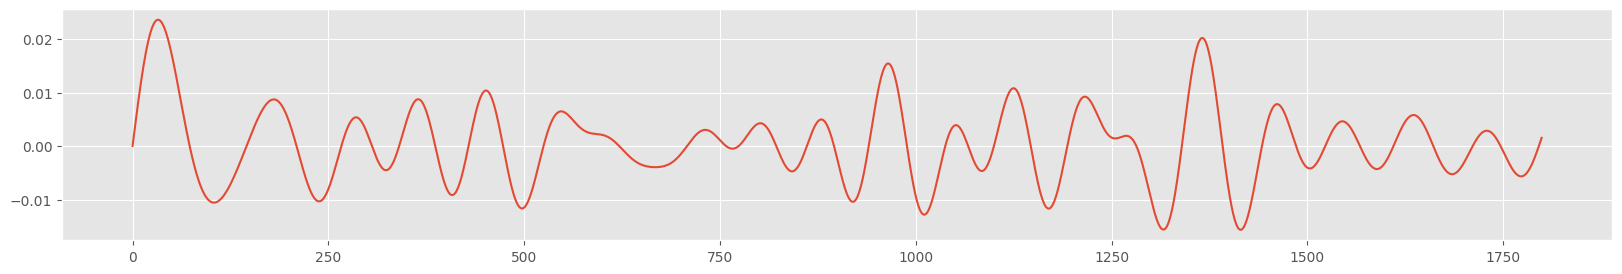

In [131]:
plt.figure(figsize=(20,3))
plt.plot(bidmc_test[0,1][0,0])
plt.show()

In [111]:
bidmc_test = bidmc_test[1][1]
bidmc_test.shape

(421, 2)

In [113]:
X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(bidmc_test), bidmc_test[:, 1].reshape(-1,1)
X_bidmc_np_test.shape, y_bidmc_np_test.shape

((421, 1800, 1), (421, 1))

In [114]:
ix = 300
err_bian_test = get_predict_performance(test_bian, X_bidmc_np_test[ix].reshape(1,-1,1), y_bidmc_np_test[ix].reshape(1,1))
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

1/1 [==============================] - 0s 27ms/step
2.1165 ± 0.0000


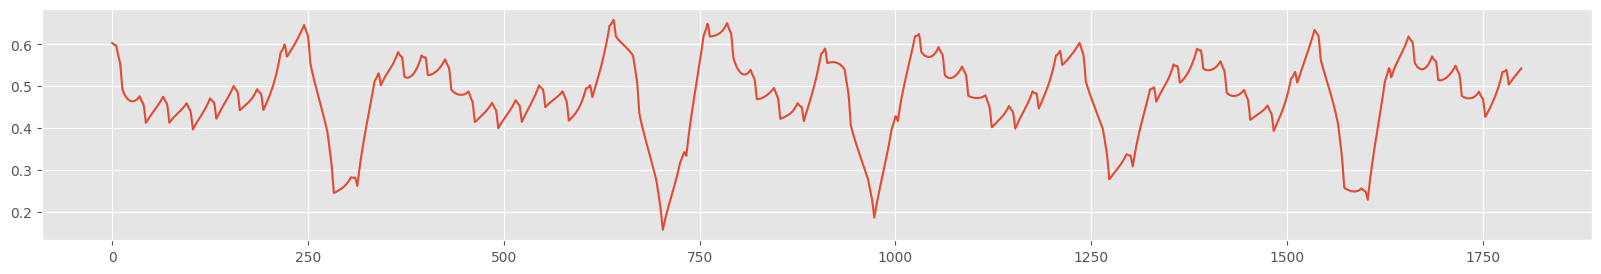

In [116]:
plot_sig(X_bidmc_np_test[ix])

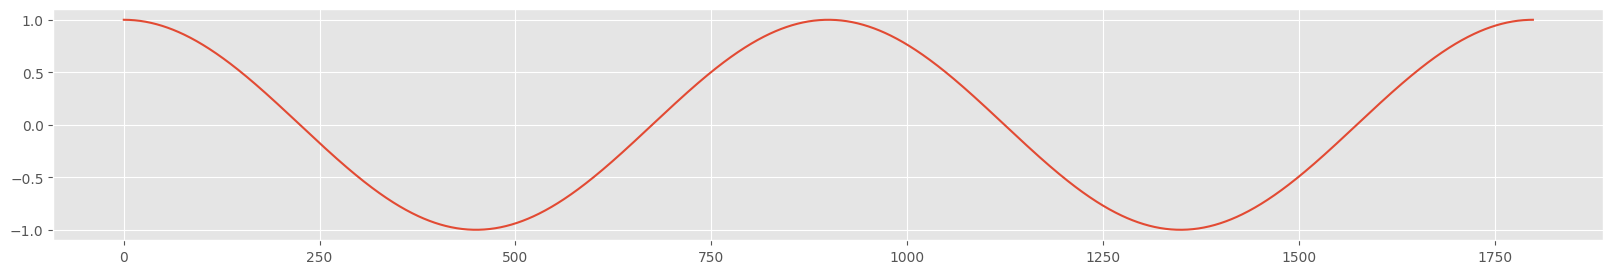

In [76]:
syn_sig1 = gen_signal(f=2, t=1800)
plot_sig(syn_sig1)

In [67]:
## SNR = 20db
sig_powers = np.array([np.mean(arr) for arr in bidmc_test[:,0]])
sig_powers.shape

(421,)

In [68]:
avgN = sig_powers[0]/20
avgN

1.6547316659712133e-05

In [ ]:
syn_sig1 = 